<a href="https://colab.research.google.com/github/FokrulBhuiyan/Machine-Learning/blob/master/flowers_recognition_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ToDo

1. pick a dataset
2. import with pytoch
3. analysis the dataset
4. prepare for training

### Download dataset and cleaning

In [1]:
pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
download_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [3]:
import shutil
import os

if os.path.exists('./flowers-recognition'):
  shutil.rmtree(data_dir + './flowers-recognition')

In [4]:
od.download(download_url)

  0%|          | 0.00/450M [00:00<?, ?B/s]

100%|██████████| 450M/450M [00:04<00:00, 98.5MB/s]


In [6]:
data_dir = './flowers-recognition/flowers'

In [7]:
os.listdir(data_dir)

['flowers', 'sunflower', 'daisy', 'tulip', 'dandelion', 'rose']

There have 2 same dir named `flowers`, so remove it first from child dir.

In [8]:
shutil.rmtree(data_dir + '/flowers')

In [9]:
os.listdir(data_dir)

['sunflower', 'daisy', 'tulip', 'dandelion', 'rose']

In [10]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir+'/'+cls)))

sunflower : 734
daisy : 769
tulip : 984
dandelion : 1055
rose : 784


## Import dataset

1. install first before import pytorch

In [11]:
from torchvision.datasets import ImageFolder

In [12]:
dataset = ImageFolder(data_dir)

In [13]:
len(dataset)

4323

In [14]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

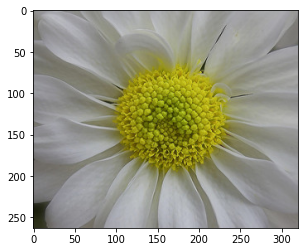

In [16]:
img, label = dataset[0]
plt.imshow(img)

In [17]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

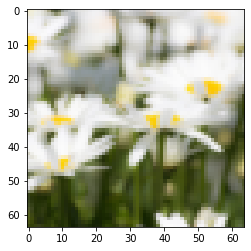

In [18]:
img, label = dataset[100]
plt.imshow(img.permute((1,2,0)))

In [19]:
val_prct= 0.1
val_size = int(val_prct*len(dataset))
train_size = len(dataset) - val_size 

train_size, val_size

(3891, 432)

In [20]:
from torch.utils.data import random_split as rs

train_data, val_data = rs(dataset,[train_size,val_size])


In [21]:
from torch.utils.data import DataLoader
batch_size = 128

train_dl = DataLoader(train_data, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)
val_dl = DataLoader(val_data, 
                      batch_size, 
                      num_workers=4, 
                      pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize =(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow =16).permute(1,2,0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


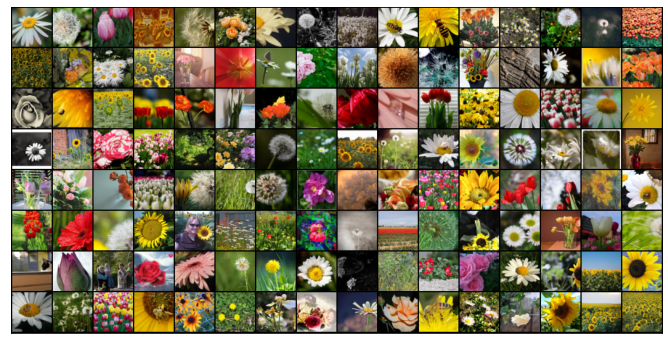

In [23]:
show_batch(train_dl)

### GPU Utility Func & Classess

In [24]:
import torch

def get_default_device():
  """Pick GPU if available,else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)
  
  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [25]:
torch.cuda.is_available()

True

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
img,label = dataset[0]

In [28]:
img.shape

torch.Size([3, 64, 64])

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model & Training Utilties

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [32]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [33]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

check one batch through model.

In [34]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


### Training

In [35]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.169921875, 'val_loss': 1.6110148429870605}]

In [36]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.4423, val_loss: 1.7546, val_acc: 0.3034
Epoch [1], train_loss: 0.9887, val_loss: 1.1192, val_acc: 0.5645
Epoch [2], train_loss: 0.8893, val_loss: 1.0522, val_acc: 0.6191
Epoch [3], train_loss: 0.7891, val_loss: 0.8515, val_acc: 0.6777
Epoch [4], train_loss: 0.7082, val_loss: 0.7364, val_acc: 0.7448


In [37]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.8698, val_loss: 0.8231, val_acc: 0.6986
Epoch [1], train_loss: 0.6852, val_loss: 0.8771, val_acc: 0.6706
Epoch [2], train_loss: 0.6078, val_loss: 0.8526, val_acc: 0.7051
Epoch [3], train_loss: 0.5730, val_loss: 0.7294, val_acc: 0.7292
Epoch [4], train_loss: 0.5481, val_loss: 0.6734, val_acc: 0.7415


In [38]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.4200, val_loss: 0.5315, val_acc: 0.8132
Epoch [1], train_loss: 0.3504, val_loss: 0.5291, val_acc: 0.7923
Epoch [2], train_loss: 0.3321, val_loss: 0.5362, val_acc: 0.7812
Epoch [3], train_loss: 0.3179, val_loss: 0.5496, val_acc: 0.8060
Epoch [4], train_loss: 0.3115, val_loss: 0.5328, val_acc: 0.8190


In [39]:
history += fit(5, 0.0001, model, train_dl, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2866, val_loss: 0.5075, val_acc: 0.8190
Epoch [1], train_loss: 0.2761, val_loss: 0.5019, val_acc: 0.8132
Epoch [2], train_loss: 0.2871, val_loss: 0.5035, val_acc: 0.8164
Epoch [3], train_loss: 0.2586, val_loss: 0.5077, val_acc: 0.8092
Epoch [4], train_loss: 0.2768, val_loss: 0.4847, val_acc: 0.8216


In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

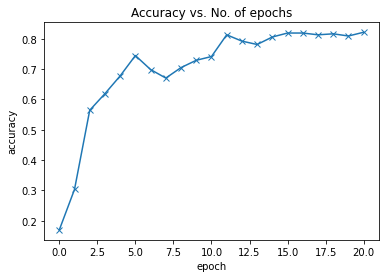

In [41]:
plot_accuracies(history)

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

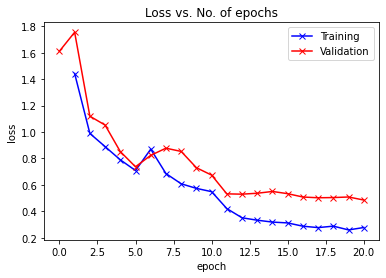

In [43]:
plot_losses(history)

## Result Record

- image size = 64
- batch size = 128
- arch = resnet9
- epoch = 20(per 5)
- lr = 2 times 0.001, 2 times 0.0001
- opt = adam*3, sgd*1

In [44]:
history[-1]

{'train_loss': 0.27681535482406616,
 'val_acc': 0.8216145634651184,
 'val_loss': 0.4847158193588257}

## test the model

In [47]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [54]:
def show_img_label(img, label):
  plt.imshow(img.permute(1,2,0))
  pred = predict_image(img, model, dataset.classes)
  print('target label: ', dataset.classes[label])
  print('prediction label: ', pred)


target label:  rose
prediction label:  rose


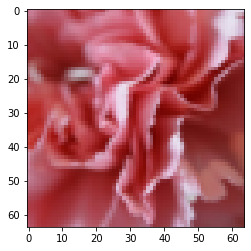

In [57]:
show_img_label(*val_data[256])

target label:  sunflower
prediction label:  sunflower


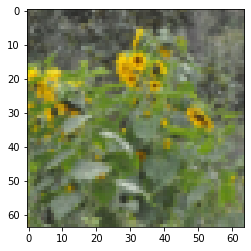

In [58]:
show_img_label(*val_data[25])